<a href="https://colab.research.google.com/github/sulaiman-shamasna/github-demo/blob/main/Torchvision_finetuning_handwritten_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchVision Handwritten Texts Detection Finetuning 

For this tutorial, I will be finetuning a pre-trained [Faster R-CNN](https://arxiv.org/abs/1506.01497) model on the [*Auction Catalogs Dataset*](https://drive.google.com/file/d/1DT-OGx8AqgX8CeiZlaeYR5NPofYE4AeA/view?usp=sharing), with the corresponding `json` file [*json_file*](https://drive.google.com/file/d/1L3VdWbapK3WRvw4pDz6h3O9reCCMIOuR/view?usp=sharing) . It contains 100 images (It's meant to be small just to be able to run it here quickly, it could of course be changed into a bigger one), and I will use it to illustrate how to use the new features in torchvision in order to train an object detection model on a custom dataset.

First, `pycocotools` needs to be installed. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-64rizp42
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-64rizp42
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=386212 sha256=6fddd3b9180a0cf2599c158aa3ce44ec6ceb86cc2080eacad6f0fa592a602cec
  Stored in directory: /tmp/pip-ephem-wheel-cache-vjr2i7zb/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.

## Getting the Dataset

To get the dataset, please connect to google dreive and import the `json` file. Please download the dataset and upload it to your google drive. Moreover, load the `json` file here to avoide any confusion!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import json
  
f = open('CATALOGS.json')
data = json.load(f)


path = 'content/drive/MyDrive/Colab CATALOGS.zip'
!unzip -uq "/content/drive/My Drive/CATALOGS.zip"

## Defining the Dataloader

In [6]:

import os, sys
import numpy as np
import torch
from PIL import Image
import cv2

import torchvision
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import json

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_masks(img, bbox):

    W,H = img.size
    zeros = torch.zeros(4,H,W)
    masks = zeros.to(dtype=torch.uint8)
    bbox1 = bbox[0]
    bbox2 = bbox[1]
    bbox3 = bbox[2]
    bbox4 = bbox[3]

    masks[0,bbox1[1]:bbox1[3], bbox1[0]:bbox1[2]] = 1
    masks[1,bbox2[1]:bbox2[3], bbox2[0]:bbox2[2]] = 1
    masks[2,bbox3[1]:bbox3[3], bbox3[0]:bbox3[2]] = 1
    masks[3,bbox4[1]:bbox4[3], bbox4[0]:bbox4[2]] = 1

  
    return masks

class CatalogsDataset(torch.utils.data.Dataset):
    def __init__(self, root, json_path, transforms=None):
        self.root = root    
        self.json_path = json_path
        self.data = json.load(open(self.json_path)) 
        self.imgs = [i['file_name'] for i in self.data['images']]
        self.masks = [i['file_name'] for i in self.data['images']] 
        self.bbox = [i['bbox'] for i in self.data['annotations']] 
        self.area = [i['area'] for i in self.data['annotations']] 
        self.label = [i['categoty_id'] for i in self.data['annotations']] 

        self.transforms = transforms


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        bbox = self.bbox[idx]

        # masks = get_masks(img, bbox)
        num_boxes = len(bbox)
        bbox = torch.as_tensor(bbox, dtype=torch.float32).reshape(num_boxes,4)


        area = self.area[idx]
        areas = torch.Tensor(area)
        label = torch.ones((num_boxes,), dtype=torch.int64) 
        image_id = torch.tensor([idx])

        iscrowd = torch.zeros((num_boxes,), dtype=torch.int64)

        target = {}
        target["boxes"] = bbox
        target["labels"] = label
        # target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
          img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

This is here just to visualize a random example from the dataset.

In [7]:
dataset = CatalogsDataset('CATALOGS/', 'CATALOGS.json')

In [ ]:
dataset[0]

## Defining the Model
###  (1) Finetuning from a pretrained model

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model



## Cloning Necessary Stuff

In [11]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 334209, done.
remote: Counting objects: 100% (50250/50250), done.
remote: Compressing objects: 100% (1144/1144), done.
remote: Total 334209 (delta 49681), reused 49538 (delta 49084), pack-reused 283959
Receiving objects: 100% (334209/334209), 673.51 MiB | 36.59 MiB/s, done.
Resolving deltas: 100% (307647/307647), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [15]:
# pip install torch._six

## Importing Necessary Files and Defining the Transforms.

IMPORTANT: You might encounter problem here with some dependencies, however please comment in line 8 (import torch._six).

In [18]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Testing forward() Method (Optional)

In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = CatalogsDataset('CATALOGS/', 'CATALOGS.json', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
dataset_test = CatalogsDataset('CATALOGS/', 'CATALOGS.json', get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

## Creating Train and Test Datasets

In [21]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

In [22]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

## Defining Training Settings and Writing the Trainig Loop

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [26]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)
  
torch.save(model.state_dict(), 'TRAINED-MODEL-DICT.pth')
torch.save(model,'TRAINED-MODEL.pth')

Epoch: [0]  [ 0/11]  eta: 0:00:30  lr: 0.000505  loss: 0.9763 (0.9763)  loss_classifier: 0.3024 (0.3024)  loss_box_reg: 0.4749 (0.4749)  loss_objectness: 0.1196 (0.1196)  loss_rpn_box_reg: 0.0795 (0.0795)  time: 2.8149  data: 1.9964  max mem: 2641
Epoch: [0]  [10/11]  eta: 0:00:00  lr: 0.005000  loss: 0.7970 (0.7963)  loss_classifier: 0.2632 (0.2631)  loss_box_reg: 0.3687 (0.3378)  loss_objectness: 0.1099 (0.1223)  loss_rpn_box_reg: 0.0552 (0.0732)  time: 0.8038  data: 0.2374  max mem: 2648
Epoch: [0] Total time: 0:00:09 (0.8373 s / it)
Epoch: [1]  [ 0/11]  eta: 0:00:39  lr: 0.000500  loss: 0.5236 (0.5236)  loss_classifier: 0.2153 (0.2153)  loss_box_reg: 0.2007 (0.2007)  loss_objectness: 0.0743 (0.0743)  loss_rpn_box_reg: 0.0333 (0.0333)  time: 3.5462  data: 2.7459  max mem: 2648
Epoch: [1]  [10/11]  eta: 0:00:00  lr: 0.000500  loss: 0.6641 (0.8165)  loss_classifier: 0.2482 (0.2839)  loss_box_reg: 0.3459 (0.3860)  loss_objectness: 0.0743 (0.0804)  loss_rpn_box_reg: 0.0333 (0.0662)  tim

## Testing a Trained Model
Here you can test the trained  model by selecting an exampe from the dataset, visualizing it, and draw the predicted bboxes afterwards. The Result will be saved in the given path.

In [28]:
# pick one image from the test set
img, _ = dataset[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

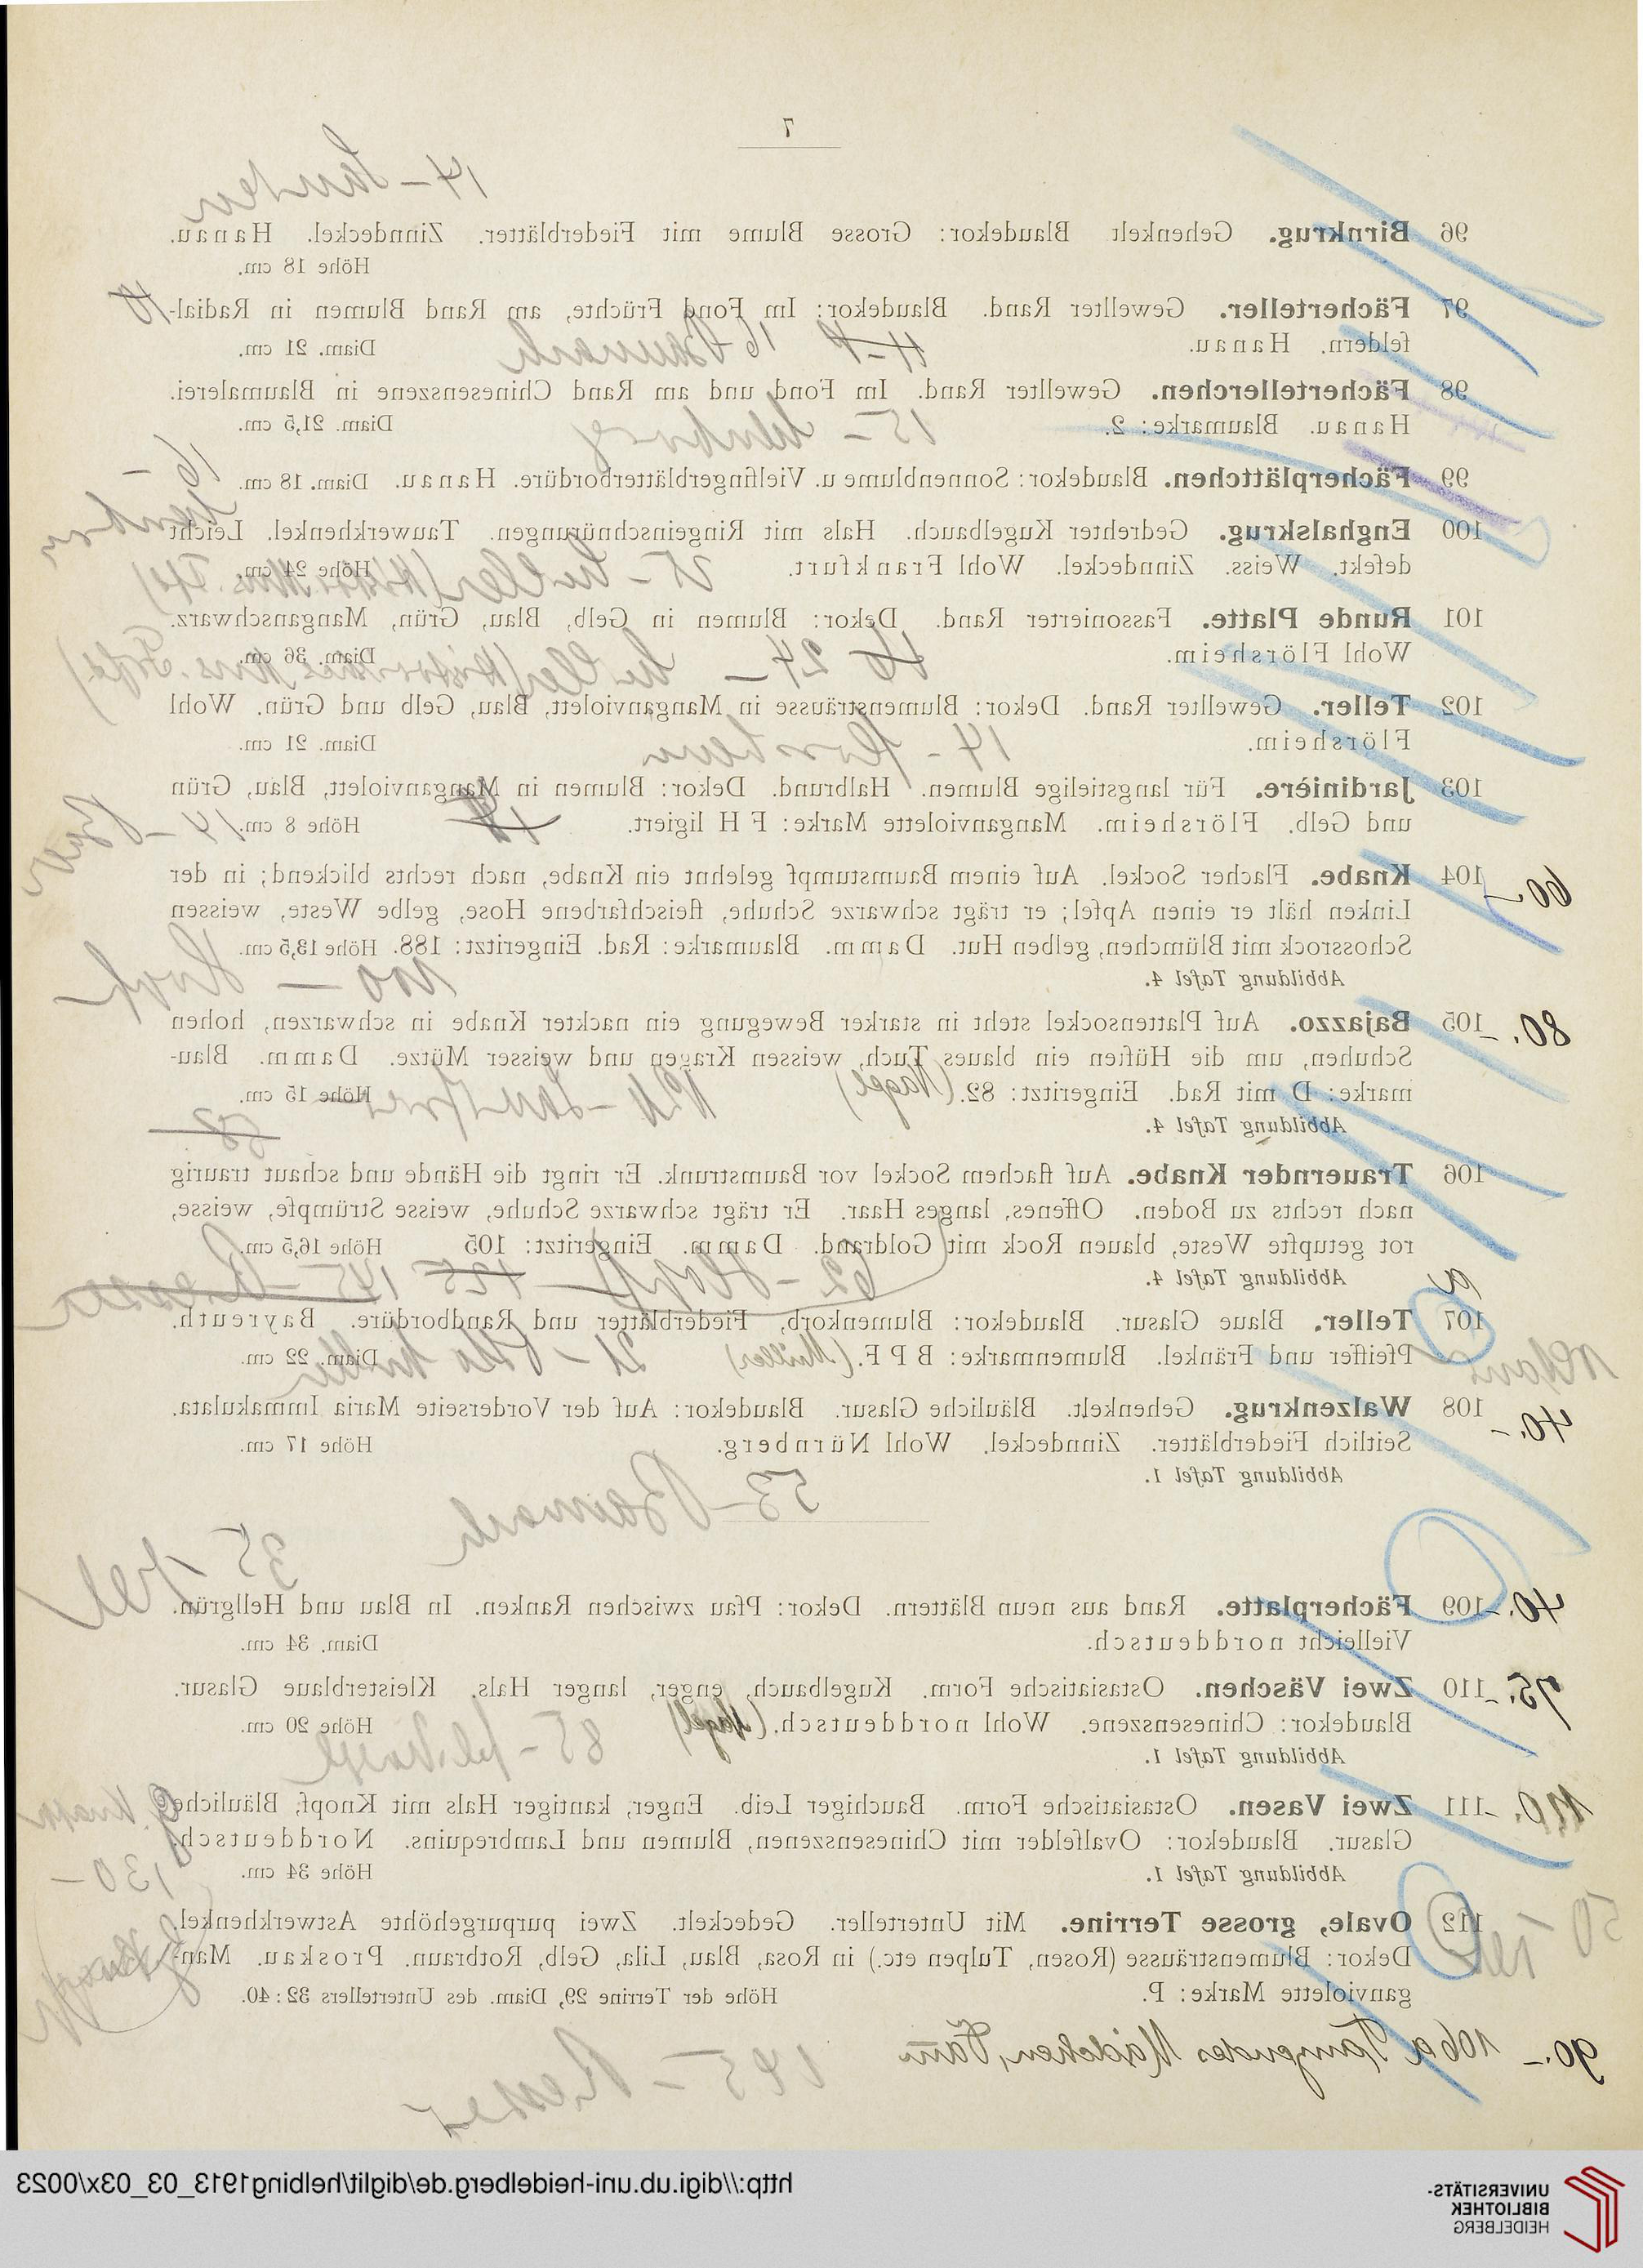

In [29]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [40]:
#Image.fromarray(prediction[0]['boxes'][0, 0].mul(255).byte().cpu().numpy())
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

Boxes = prediction[0]['boxes']

img_id = 'cassirer_helbing1926_04_27xx_0015.jpg'
img = read_image('CATALOGS/' + img_id)

img = draw_bounding_boxes(img, Boxes, width=3, colors=(255,255,0))
img = torchvision.transforms.ToPILImage()(img)
img.save('predicted_image.jpg')